In [4]:
# === Local Settings (v6) ===
from pathlib import Path

USE_GPU = True  # GPUがない場合はFalseにする
DATA_PATH = Path("usd_jpy_1min_20231028_20260131_utc.parquet")
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

def catboost_device_params():
    return {"task_type": "GPU", "devices": "0"} if USE_GPU else {"task_type": "CPU"}

try:
    from google.colab import files  # type: ignore
    _HAS_COLAB = True
except Exception:
    _HAS_COLAB = False

def maybe_download(path: Path):
    if _HAS_COLAB:
        files.download(str(path))
    else:
        print(f"📁 Saved locally: {path}")



In [5]:
# === Cell 1: Setup Environment (v6) ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna
import shap
import pickle
import warnings
import random
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    log_loss, classification_report, accuracy_score,
    confusion_matrix, precision_recall_fscore_support,
    cohen_kappa_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# === Configuration (v6: Trading-First + Time Feature Cap) ===
CONFIG = {
    # ターゲット設定
    'PREDICT_HORIZON': 15,           # 予測期間（分）
    'THRESHOLD_PIPS_MIN': 2,         # 閾値最適化範囲（pips）
    'THRESHOLD_PIPS_MAX': 10,
    'THRESHOLD_PIPS_DEFAULT': 5,

    # 特徴量選択
    'TOP_N_FEATURES': 40,

    # モデル設定
    'RANDOM_SEED': 42,
    'N_TRIALS': 40,
    'CV_SPLITS': 5,

    # データ分割比率
    'TRAIN_RATIO': 0.6,
    'VAL_RATIO': 0.2,
    'TEST_RATIO': 0.2,

    # コスト設定（pips）
    'PIP_SIZE': 0.01,                # USD/JPY: 1 pip = 0.01
    'SPREAD_PIPS': 0.4,              # スプレッド（pips）
    'SLIPPAGE_PIPS': 0.05,           # スリッページ（pips）

    # バックテスト設定
    'POSITION_SIZE': 10000,          # ポジションサイズ（通貨単位）

    # 推論・評価フィルタ
    'BAD_HOURS': [20, 21, 22, 23],   # スプレッド異常時間帯（UTC）
    'ATR_PERCENTILE': 30,            # ATRフィルタの閾値パーセンタイル
    'TIMEZONE': 'UTC',
    'EVAL_USE_ATR_FILTER': True,
    'EVAL_USE_BAD_HOURS': True,

    # 最適化制約
    'MIN_TRADES_ABS': 300,           # 最低トレード数（絶対）
    'MIN_TRADES_RATE': 0.003,        # 取引率下限（0.3%）
    'MIN_SIDE_TRADES': 20,           # Buy/Sellの最低トレード数

    # 予測確率の範囲（Optuna/閾値探索）
    'PROB_THRESHOLD_MIN': 0.30,
    'PROB_THRESHOLD_MAX': 0.70,

    # 時間特徴の扱い
    'TIME_FEATURE_POLICY': 'cap',    # keep / cap / drop
    'MAX_TIME_FEATURES': 4,

    # Sharpe年率化用（1分足換算）
    'BAR_PER_YEAR': int(252 * 24 * 60),
}

# purge gap = 予測期間
CONFIG['CV_GAP'] = CONFIG['PREDICT_HORIZON']

np.random.seed(CONFIG['RANDOM_SEED'])
random.seed(CONFIG['RANDOM_SEED'])

print("✅ Libraries installed and imported.")
print("📊 Configuration (v6):")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")



✅ Libraries installed and imported.
📊 Configuration (v6):
   PREDICT_HORIZON: 15
   THRESHOLD_PIPS_MIN: 2
   THRESHOLD_PIPS_MAX: 10
   THRESHOLD_PIPS_DEFAULT: 5
   TOP_N_FEATURES: 40
   RANDOM_SEED: 42
   N_TRIALS: 40
   CV_SPLITS: 5
   TRAIN_RATIO: 0.6
   VAL_RATIO: 0.2
   TEST_RATIO: 0.2
   PIP_SIZE: 0.01
   SPREAD_PIPS: 0.4
   SLIPPAGE_PIPS: 0.05
   POSITION_SIZE: 10000
   BAD_HOURS: [20, 21, 22, 23]
   ATR_PERCENTILE: 30
   TIMEZONE: UTC
   EVAL_USE_ATR_FILTER: True
   EVAL_USE_BAD_HOURS: True
   MIN_TRADES_ABS: 300
   MIN_TRADES_RATE: 0.003
   MIN_SIDE_TRADES: 20
   PROB_THRESHOLD_MIN: 0.3
   PROB_THRESHOLD_MAX: 0.7
   TIME_FEATURE_POLICY: cap
   MAX_TIME_FEATURES: 4
   BAR_PER_YEAR: 362880
   CV_GAP: 15


⏳ Loading Data & Generating Features (v6)...

📊 Data Prepared: 833543 rows, 95 features

📈 Class Distribution (threshold 5 pips):
   Hold: 483,201 (57.97%)
   Buy: 178,369 (21.40%)
   Sell: 171,973 (20.63%)


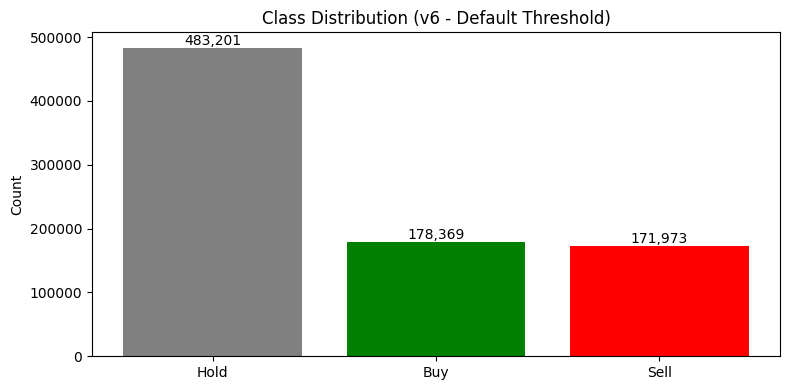

In [6]:
# === Cell 2: Data Loading & Feature Engineering (v6) ===
print("⏳ Loading Data & Generating Features (v6)...")

def select_ohlc_columns_v6(df: pd.DataFrame):
    df = df.copy()

    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    elif 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

    # close
    if 'close' not in df.columns:
        if {'ask_close', 'bid_close'}.issubset(df.columns):
            df['close'] = (df['ask_close'] + df['bid_close']) / 2
        elif 'ask_close' in df.columns:
            df['close'] = df['ask_close']
        elif 'bid_close' in df.columns:
            df['close'] = df['bid_close']
        else:
            num_cols = df.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("No numeric columns found to infer close.")
            df['close'] = df[num_cols[0]]

    # volume
    if 'volume' not in df.columns:
        df['volume'] = df.get('tick_volume', 1.0)

    if all(c in df.columns for c in ['open', 'high', 'low']):
        open_col, high_col, low_col = 'open', 'high', 'low'
    elif all(c in df.columns for c in ['ask_open', 'ask_high', 'ask_low']):
        open_col, high_col, low_col = 'ask_open', 'ask_high', 'ask_low'
    elif all(c in df.columns for c in ['bid_open', 'bid_high', 'bid_low']):
        open_col, high_col, low_col = 'bid_open', 'bid_high', 'bid_low'
    else:
        open_col = high_col = low_col = 'close'

    price_cols = {'open': open_col, 'high': high_col, 'low': low_col, 'close': 'close', 'volume': 'volume'}
    return df, price_cols


def generate_features_v6(df: pd.DataFrame, price_cols: dict):
    calc_df = df.copy()

    # TA特徴量
    calc_df = ta.add_all_ta_features(
        calc_df,
        open=price_cols['open'],
        high=price_cols['high'],
        low=price_cols['low'],
        close=price_cols['close'],
        volume=price_cols['volume'],
        fillna=True
    )

    calc_df = calc_df.replace([np.inf, -np.inf], np.nan)

    new_cols = {}

    # 移動平均乖離率
    for window in [20, 50, 100, 200]:
        sma = calc_df['close'].rolling(window).mean()
        new_cols[f'ma_dist_{window}'] = (calc_df['close'] - sma) / sma

    # EMA乖離率
    for window in [12, 26]:
        ema = calc_df['close'].ewm(span=window).mean()
        new_cols[f'ema_dist_{window}'] = (calc_df['close'] - ema) / ema

    # ボラティリティ関連
    if 'volatility_atr' in calc_df.columns:
        new_cols['atr_ratio'] = calc_df['volatility_atr'] / calc_df['volatility_atr'].rolling(30).mean()
    else:
        new_cols['atr_ratio'] = 1.0

    if 'volatility_bbh' in calc_df.columns and 'volatility_bbl' in calc_df.columns:
        new_cols['bb_width'] = (calc_df['volatility_bbh'] - calc_df['volatility_bbl']) / calc_df['close']

    # リターン系特徴量
    for lag in [1, 5, 15, 60]:
        new_cols[f'return_{lag}'] = calc_df['close'].pct_change(lag)

    # 時間特徴量 (Sin/Cos)
    idx = calc_df.index
    new_cols['hour_sin'] = np.sin(2 * np.pi * idx.hour / 24)
    new_cols['hour_cos'] = np.cos(2 * np.pi * idx.hour / 24)
    new_cols['minute_sin'] = np.sin(2 * np.pi * idx.minute / 60)
    new_cols['minute_cos'] = np.cos(2 * np.pi * idx.minute / 60)
    new_cols['day_sin'] = np.sin(2 * np.pi * idx.dayofweek / 7)
    new_cols['day_cos'] = np.cos(2 * np.pi * idx.dayofweek / 7)

    # セッション特徴量
    new_cols['is_tokyo_session'] = ((idx.hour >= 0) & (idx.hour < 9)).astype(int)
    new_cols['is_london_session'] = ((idx.hour >= 8) & (idx.hour < 17)).astype(int)
    new_cols['is_ny_session'] = ((idx.hour >= 13) & (idx.hour < 22)).astype(int)

    new_cols_df = pd.DataFrame(new_cols, index=calc_df.index)
    calc_df = pd.concat([calc_df, new_cols_df], axis=1)

    calc_df = calc_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return calc_df


# 1. データ読み込み
df = pd.read_parquet(DATA_PATH)
df, price_cols = select_ohlc_columns_v6(df)

# 2. 特徴量生成
df_features = generate_features_v6(df, price_cols)

# 3. 数値列のみ抽出
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
exclude_keywords = ['ask_', 'bid_', 'timestamp', 'future', 'target', 'tick_', 'open', 'high', 'low', 'close', 'volume']
feature_cols = [c for c in numeric_cols if not any(k in c for k in exclude_keywords)]
X_all = df_features[feature_cols].copy()

# 時間特徴量一覧
TIME_FEATURES = [
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
    'is_tokyo_session', 'is_london_session', 'is_ny_session'
]

# 4. ターゲット生成（pips基準）
future_returns_pips = (df['close'].shift(-CONFIG['PREDICT_HORIZON']) - df['close']) / CONFIG['PIP_SIZE']
y_all = pd.Series(0, index=df.index)  # 0 = Hold
y_all[future_returns_pips > CONFIG['THRESHOLD_PIPS_DEFAULT']] = 1   # Buy
y_all[future_returns_pips < -CONFIG['THRESHOLD_PIPS_DEFAULT']] = 2  # Sell

# 5. データクリーニング
valid_indices = X_all.dropna().index.intersection(y_all.index)
valid_indices = valid_indices[:-CONFIG['PREDICT_HORIZON']]

X = X_all.loc[valid_indices]
y = y_all.loc[valid_indices]
future_returns_pips_valid = future_returns_pips.loc[valid_indices]

# クラス分布確認
print(f"\n📊 Data Prepared: {len(X)} rows, {X.shape[1]} features")

print(f"\n📈 Class Distribution (threshold {CONFIG['THRESHOLD_PIPS_DEFAULT']} pips):")

class_counts = y.value_counts().sort_index()
class_labels = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
for cls, count in class_counts.items():
    print(f"   {class_labels[cls]}: {count:,} ({count/len(y)*100:.2f}%)")

# 可視化
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar([class_labels[i] for i in class_counts.index], class_counts.values, color=['gray', 'green', 'red'])
ax.set_title('Class Distribution (v6 - Default Threshold)')
ax.set_ylabel('Count')
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()



In [7]:
# === Cell 3: Purged Train/Val/Test Split (v6) ===
print("⏳ Creating Purged Train/Val/Test split (v6)...")

def purged_time_series_split_v6(n_samples, n_splits, gap):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(np.arange(n_samples)):
        if gap > 0:
            if len(train_idx) > gap:
                train_idx = train_idx[:-gap]
            else:
                train_idx = train_idx[:0]
        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        yield train_idx, val_idx

gap = CONFIG['CV_GAP']
num_rows = len(X)

train_end = int(num_rows * CONFIG['TRAIN_RATIO'])
val_end = int(num_rows * (CONFIG['TRAIN_RATIO'] + CONFIG['VAL_RATIO']))

train_idx = np.arange(0, train_end)
val_start = min(train_end + gap, num_rows)
val_end = min(val_end, num_rows)
val_idx = np.arange(val_start, val_end)
test_start = min(val_end + gap, num_rows)
test_idx = np.arange(test_start, num_rows)

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

future_returns_pips_train = future_returns_pips_valid.loc[X_train.index]
future_returns_pips_val = future_returns_pips_valid.loc[X_val.index]
future_returns_pips_test = future_returns_pips_valid.loc[X_test.index]

print(f"📊 Data Split (v6, purged):")
print(f"   Gap: {gap} rows")
print(f"   Train: {len(X_train):,} ({len(X_train)/num_rows*100:.1f}%)")
print(f"   Validation: {len(X_val):,} ({len(X_val)/num_rows*100:.1f}%)")
print(f"   Test: {len(X_test):,} ({len(X_test)/num_rows*100:.1f}%)")

if min(len(X_train), len(X_val), len(X_test)) == 0:
    print("⚠️ One of the splits is empty. Adjust ratios or check data length.")



⏳ Creating Purged Train/Val/Test split (v6)...
📊 Data Split (v6, purged):
   Gap: 15 rows
   Train: 500,125 (60.0%)
   Validation: 166,694 (20.0%)
   Test: 166,694 (20.0%)


⏳ Selecting Important Features (v6, Train Only)...

⚠️ 警告: Top 20中に時間特徴量が6個含まれています！
   該当特徴量: ['hour_cos', 'minute_cos', 'hour_sin', 'minute_sin', 'day_sin', 'day_cos']
   時間帯パターンは市場構造の変化で無効化される可能性があります。

📊 Top 20 Features:
                    feature  importance
10           volatility_kcw   24.997830
19           volatility_atr   13.021915
87                 hour_cos    7.572843
89               minute_cos    5.822494
86                 hour_sin    4.749647
88               minute_sin    4.575582
77              ma_dist_200    4.423815
80                atr_ratio    3.299930
90                  day_sin    3.138810
45  trend_visual_ichimoku_b    2.689110
44  trend_visual_ichimoku_a    2.206974
91                  day_cos    2.022605
17           volatility_dcw    2.012958
40                trend_adx    1.575570
30         trend_mass_index    1.413973
20            volatility_ui    1.230279
33            trend_kst_sig    1.108335
2            volatility_bbl    1.073485
27     trend_vor

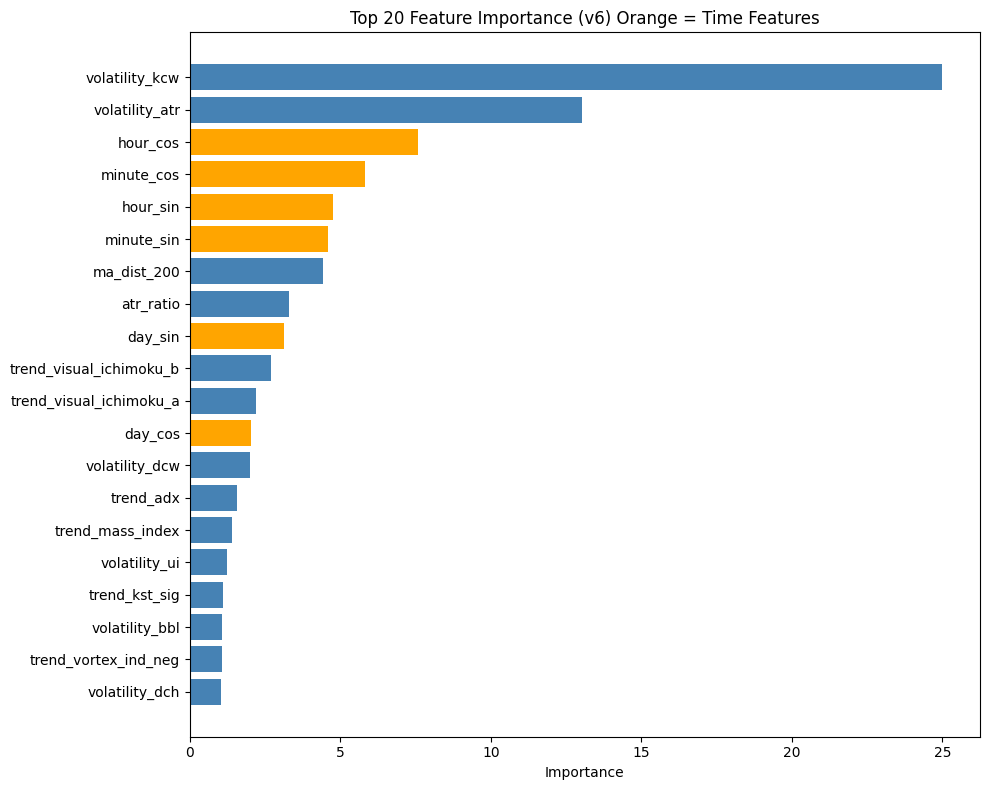

In [9]:
# === Cell 4: Feature Selection with Purged CV (Train Only, v6) ===
print("⏳ Selecting Important Features (v6, Train Only)...")

importance_scores = []

for fold, (train_idx, val_idx) in enumerate(purged_time_series_split_v6(len(X_train), n_splits=3, gap=CONFIG['CV_GAP'])):
    X_train_fs, X_val_fs = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fs, y_val_fs = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # クラス重み計算
    classes = np.unique(y_train_fs)
    weights = compute_class_weight('balanced', classes=classes, y=y_train_fs)
    class_weights = dict(zip(classes, weights))

    temp_model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        class_weights=class_weights,
        **catboost_device_params(),
        verbose=0,
        random_seed=CONFIG['RANDOM_SEED']
    )

    temp_model.fit(X_train_fs, y_train_fs, eval_set=(X_val_fs, y_val_fs), early_stopping_rounds=30)
    importance_scores.append(temp_model.get_feature_importance())

if not importance_scores:
    raise RuntimeError("No valid folds for feature selection. Check data length or CV gap.")

# 平均重要度で選択
avg_importance = np.mean(importance_scores, axis=0)
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': avg_importance})
df_imp = df_imp.sort_values('importance', ascending=False)

# 時間特徴量の警告
time_features = TIME_FEATURES
policy = CONFIG['TIME_FEATURE_POLICY'].lower()

top20 = df_imp.head(20)['feature'].tolist()
time_in_top20 = [f for f in top20 if f in time_features]

if len(time_in_top20) >= 5:
    print(f"\n⚠️ 警告: Top 20中に時間特徴量が{len(time_in_top20)}個含まれています！")

    print(f"   該当特徴量: {time_in_top20}")
    print("   時間帯パターンは市場構造の変化で無効化される可能性があります。")
elif len(time_in_top20) >= 3:
    print(f"\n⚡ 注意: Top 20中に時間特徴量が{len(time_in_top20)}個含まれています。")

    print(f"   該当特徴量: {time_in_top20}")

# 特徴量選択（時間特徴はポリシーに従って制限）
if policy == 'keep':
    selected_features = df_imp.head(CONFIG['TOP_N_FEATURES'])['feature'].tolist()
elif policy == 'drop':
    non_time = df_imp[~df_imp['feature'].isin(time_features)]
    selected_features = non_time.head(CONFIG['TOP_N_FEATURES'])['feature'].tolist()
elif policy == 'cap':
    time_sorted = [f for f in df_imp['feature'] if f in time_features]
    allowed_time = time_sorted[:CONFIG['MAX_TIME_FEATURES']]
    non_time = [f for f in df_imp['feature'] if f not in time_features]
    selected_features = allowed_time + non_time
    selected_features = selected_features[:CONFIG['TOP_N_FEATURES']]
else:
    raise ValueError(f"Unknown TIME_FEATURE_POLICY: {policy}")

time_selected = [f for f in selected_features if f in time_features]

print(f"\n📊 Top 20 Features:")

print(df_imp.head(20).to_string())
print(f"\n✅ Selected Top {CONFIG['TOP_N_FEATURES']} features for training.")

print(f"   Time features used: {len(time_selected)} (policy={policy})")

# データセットを更新
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# 特徴量重要度の可視化
fig, ax = plt.subplots(figsize=(10, 8))
top20_df = df_imp.head(20).iloc[::-1]
colors = ['orange' if f in time_features else 'steelblue' for f in top20_df['feature']]
ax.barh(top20_df['feature'], top20_df['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (v6) Orange = Time Features')
plt.tight_layout()
plt.show()



In [13]:
# === Cell 5: Hyperparameter Tuning with Optuna (v6: Trading Objective) ===
print("⏳ Starting Bayesian Optimization (v6, trading objective)...")

def create_target_with_threshold(future_returns_pips, threshold_pips):
    y = pd.Series(0, index=future_returns_pips.index)
    y[future_returns_pips > threshold_pips] = 1   # Buy
    y[future_returns_pips < -threshold_pips] = 2  # Sell
    return y


def calculate_sharpe_ratio(returns, bar_per_year, trade_rate):
    if len(returns) == 0:
        return 0.0
    r = np.asarray(returns, dtype=float)
    if r.std() == 0:
        return 0.0
    periods_per_year = max(1.0, bar_per_year * trade_rate)
    return np.sqrt(periods_per_year) * (r.mean() / r.std())


def calc_trade_pnl_pips(preds, future_returns_pips, cost_pips):
    pnl = []
    for pred, fr in zip(preds, future_returns_pips):
        if pred == 1:
            pnl.append(fr - cost_pips)
        elif pred == 2:
            pnl.append(-fr - cost_pips)
    return np.array(pnl)


def predict_with_thresholds(probs, threshold_buy, threshold_sell):
    preds = np.zeros(len(probs), dtype=int)
    for i, (hold_p, buy_p, sell_p) in enumerate(probs):
        if buy_p > threshold_buy and buy_p > sell_p:
            preds[i] = 1
        elif sell_p > threshold_sell and sell_p > buy_p:
            preds[i] = 2
    return preds


def trade_penalty(trade_count, total_count, buy_count, sell_count, config):
    if total_count == 0:
        return 0.0
    min_trades = max(config['MIN_TRADES_ABS'], int(config['MIN_TRADES_RATE'] * total_count))
    rate_factor = min(1.0, trade_count / max(1, min_trades))
    side_factor = min(1.0, min(buy_count, sell_count) / max(1, config['MIN_SIDE_TRADES']))
    balance_factor = min(buy_count, sell_count) / max(1, max(buy_count, sell_count))
    penalty = rate_factor * side_factor * (0.5 + 0.5 * balance_factor)
    return penalty


def score_trading(preds, future_returns_pips, total_count, config, cost_pips):
    trade_count = int((preds != 0).sum())
    buy_count = int((preds == 1).sum())
    sell_count = int((preds == 2).sum())
    trade_rate = trade_count / total_count if total_count > 0 else 0.0

    pnl_pips = calc_trade_pnl_pips(preds, future_returns_pips, cost_pips)
    sharpe = calculate_sharpe_ratio(pnl_pips, config['BAR_PER_YEAR'], trade_rate)
    penalty = trade_penalty(trade_count, total_count, buy_count, sell_count, config)

    # 連続的なペナルティで低取引を抑制
    score = sharpe * penalty - (1 - penalty)
    return score


def objective_v6(trial):
    threshold_pips = trial.suggest_float('threshold_pips',
                                          CONFIG['THRESHOLD_PIPS_MIN'],
                                          CONFIG['THRESHOLD_PIPS_MAX'])
    prob_threshold = trial.suggest_float('prob_threshold',
                                         CONFIG['PROB_THRESHOLD_MIN'],
                                         CONFIG['PROB_THRESHOLD_MAX'])

    y_opt = create_target_with_threshold(future_returns_pips_train, threshold_pips)

    classes = np.unique(y_opt)
    if len(classes) < 3:
        return -1.0

    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.12, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 5.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MultiClassOneVsAll',
        'eval_metric': 'TotalF1',
        **catboost_device_params(),
        'verbose': 0,
        'early_stopping_rounds': 50,
        'random_seed': CONFIG['RANDOM_SEED']
    }

    cost_pips = CONFIG['SPREAD_PIPS'] + CONFIG['SLIPPAGE_PIPS']
    scores = []

    for train_idx, val_idx in purged_time_series_split_v6(len(X_train), n_splits=CONFIG['CV_SPLITS'], gap=CONFIG['CV_GAP']):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_opt.iloc[train_idx], y_opt.iloc[val_idx]

        # Foldごとに重み計算
        classes_fold = np.unique(y_tr)
        weights = compute_class_weight('balanced', classes=classes_fold, y=y_tr)
        class_weights = dict(zip(classes_fold, weights))

        model = CatBoostClassifier(**params, class_weights=class_weights)
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va))

        probs = model.predict_proba(X_va)
        preds = predict_with_thresholds(probs, prob_threshold, prob_threshold)

        score = score_trading(
            preds,
            future_returns_pips_train.iloc[val_idx].values,
            len(preds),
            CONFIG,
            cost_pips
        )
        scores.append(score)

    return float(np.mean(scores)) if scores else -1.0


study = optuna.create_study(direction='maximize')
study.optimize(objective_v6, n_trials=CONFIG['N_TRIALS'], show_progress_bar=True)

# 最適パラメータを保存
BEST_THRESHOLD_PIPS = study.best_params['threshold_pips']
BEST_PROB_THRESHOLD = study.best_params['prob_threshold']
print("✅ Best Parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")
print(f"\n📊 Best Trading Score: {study.best_value:.4f}")

print(f"\n🎯 Optimized THRESHOLD_PIPS: {BEST_THRESHOLD_PIPS:.4f}")

print(f"🎯 Optimized PROB_THRESHOLD: {BEST_PROB_THRESHOLD:.4f}")

# 最適閾値でターゲットを再生成（train/val/testに反映）
y_all_opt = create_target_with_threshold(future_returns_pips_valid, BEST_THRESHOLD_PIPS)
y_train = y_all_opt.loc[X_train.index]
y_val = y_all_opt.loc[X_val.index]
y_test = y_all_opt.loc[X_test.index]

# 更新後のクラス分布
print(f"\n📈 Updated Class Distribution (threshold={BEST_THRESHOLD_PIPS:.4f} pips):")

class_counts = y_all_opt.value_counts().sort_index()
for cls, count in class_counts.items():
    print(f"   {class_labels[cls]}: {count:,} ({count/len(y_all_opt)*100:.2f}%)")



⏳ Starting Bayesian Optimization (v6, trading objective)...


Best trial: 37. Best value: 0.320654: 100%|██████████| 40/40 [04:50<00:00,  7.25s/it] 

✅ Best Parameters:
   threshold_pips: 2.2339346154141957
   prob_threshold: 0.5899716630572117
   learning_rate: 0.09204687161360128
   depth: 7
   l2_leaf_reg: 0.6017224058889062
   random_strength: 0.19067109461875964
   bagging_temperature: 0.37675320635926857
   border_count: 221

📊 Best Trading Score: 0.3207

🎯 Optimized THRESHOLD_PIPS: 2.2339
🎯 Optimized PROB_THRESHOLD: 0.5900

📈 Updated Class Distribution (threshold=2.2339 pips):
   Hold: 260,058 (31.20%)
   Buy: 292,781 (35.12%)
   Sell: 280,704 (33.68%)


In [14]:
# === Cell 6: Train Final Model & Threshold Optimization (v6) ===
print("⏳ Training Final Model (v6)...")

# クラス重み計算（訓練データのみで）
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_train = dict(zip(classes, weights))
print(f"\n📊 Class Weights (from train only): {class_weights_train}")


# 最終パラメータ（THRESHOLD_PIPSは除外）
final_params = {k: v for k, v in study.best_params.items() if k not in ['threshold_pips', 'prob_threshold']}
final_params.update({
    'iterations': 3000,
    'loss_function': 'MultiClassOneVsAll',
    'eval_metric': 'TotalF1',
    'class_weights': class_weights_train,
    'verbose': 500,
    'early_stopping_rounds': 150,
    'random_seed': CONFIG['RANDOM_SEED']
})
final_params.update(catboost_device_params())

# 訓練（バリデーションデータで早期停止）
model = CatBoostClassifier(**final_params)
model.fit(X_train, y_train, eval_set=(X_val, y_val))


def optimize_thresholds_v6(model, X_val, future_returns_pips_val, df_features, config, atr_threshold):
    probs = model.predict_proba(X_val)
    idx = X_val.index

    eligible = pd.Series(True, index=idx)
    if config['EVAL_USE_BAD_HOURS']:
        eligible &= ~idx.hour.isin(config['BAD_HOURS'])
    if config['EVAL_USE_ATR_FILTER'] and 'volatility_atr' in df_features.columns:
        eligible &= df_features.loc[idx, 'volatility_atr'] >= atr_threshold

    eligible_count = int(eligible.sum())
    if eligible_count == 0:
        print("⚠️ No eligible rows for threshold optimization. Filters are too strict.")
        eligible = pd.Series(True, index=idx)
        eligible_count = len(idx)

    cost_pips = config['SPREAD_PIPS'] + config['SLIPPAGE_PIPS']
    best_score = -np.inf
    best_thresholds = (config['PROB_THRESHOLD_MIN'], config['PROB_THRESHOLD_MIN'])

    for thresh_buy in np.arange(config['PROB_THRESHOLD_MIN'], config['PROB_THRESHOLD_MAX'] + 1e-9, 0.02):
        for thresh_sell in np.arange(config['PROB_THRESHOLD_MIN'], config['PROB_THRESHOLD_MAX'] + 1e-9, 0.02):
            preds = predict_with_thresholds(probs, thresh_buy, thresh_sell)
            preds = preds.copy()
            preds[~eligible.values] = 0

            score = score_trading(
                preds,
                future_returns_pips_val.values,
                eligible_count,
                config,
                cost_pips
            )

            if score > best_score:
                best_score = score
                best_thresholds = (thresh_buy, thresh_sell)

    return best_thresholds, best_score


# === ATR閾値を学習データから固定 ===
if 'volatility_atr' in df_features.columns:
    atr_series = df_features.loc[X_train.index, 'volatility_atr']
    ATR_THRESHOLD = atr_series.quantile(CONFIG['ATR_PERCENTILE'] / 100)
else:
    ATR_THRESHOLD = 0.0
print(f"\n📈 ATR Threshold (train-based): {ATR_THRESHOLD:.6f}")


# === バリデーションデータで閾値最適化（v6: Trading Score + Live Filters）===
print("⏳ Optimizing thresholds on VALIDATION data (v6)...")
(best_thresholds, best_score) = optimize_thresholds_v6(
    model,
    X_val,
    future_returns_pips_val,
    df_features,
    CONFIG,
    ATR_THRESHOLD
)

THRESHOLD_BUY, THRESHOLD_SELL = best_thresholds
print(f"🎯 Optimized Thresholds (from validation): Buy>{THRESHOLD_BUY:.2f}, Sell>{THRESHOLD_SELL:.2f}")
print(f"📊 Best Trading Score on validation: {best_score:.4f}")



⏳ Training Final Model (v6)...

📊 Class Weights (from train only): {0: 1.0470379372646061, 1: 0.9552500792659401, 2: 1.0019252189661114}
0:	learn: 0.4299607	test: 0.3945644	best: 0.3945644 (0)	total: 10.2ms	remaining: 30.6s
bestTest = 0.4059611257
bestIteration = 10
Shrink model to first 11 iterations.

📈 ATR Threshold (train-based): 0.019409
⏳ Optimizing thresholds on VALIDATION data (v6)...
🎯 Optimized Thresholds (from validation): Buy>0.44, Sell>0.46
📊 Best Trading Score on validation: 0.5942



📊 FINAL MODEL EVALUATION ON TEST DATA (v6)

--- NO FILTER ---

📈 Overall Metrics (Test Set (No Filter)):
   Accuracy: 0.3522
   Macro F1: 0.2028
   Weighted F1: 0.2074
   Cohen's Kappa: 0.0160

📊 Classification Report (Test Set (No Filter)):
              precision    recall  f1-score   support

        Hold       0.35      0.98      0.52     56990
         Buy       0.42      0.04      0.08     56282
        Sell       0.39      0.01      0.01     53422

    accuracy                           0.35    166694
   macro avg       0.39      0.34      0.20    166694
weighted avg       0.39      0.35      0.21    166694



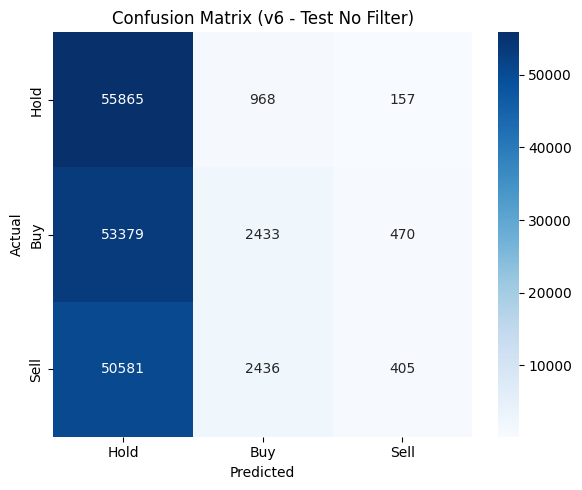

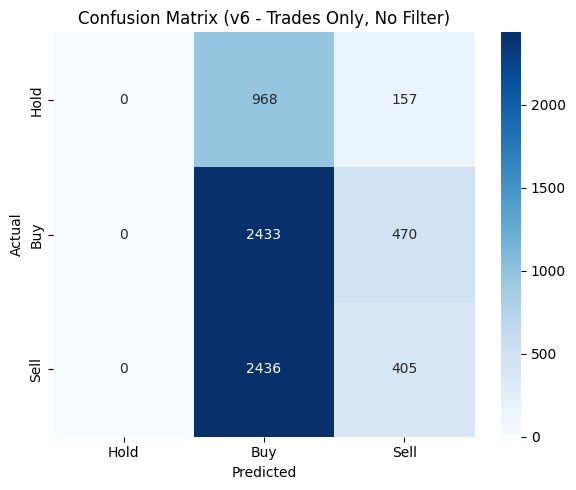


📊 Trading Metrics (No Filter):
   Total Trades: 6,869
   Win Rate: 47.4%
   Total P&L: ¥-792,355
   Avg Win: ¥943
   Avg Loss: ¥-1,070
   Profit Factor: 0.79
   Sharpe Ratio: -9.86

--- LIVE FILTER (BAD_HOURS + ATR) ---

📈 Overall Metrics (Test Set (Live Filter)):
   Accuracy: 0.3516
   Macro F1: 0.2007
   Weighted F1: 0.2053
   Cohen's Kappa: 0.0151

📊 Classification Report (Test Set (Live Filter)):
              precision    recall  f1-score   support

        Hold       0.35      0.98      0.52     56990
         Buy       0.42      0.04      0.07     56282
        Sell       0.40      0.01      0.01     53422

    accuracy                           0.35    166694
   macro avg       0.39      0.34      0.20    166694
weighted avg       0.39      0.35      0.21    166694



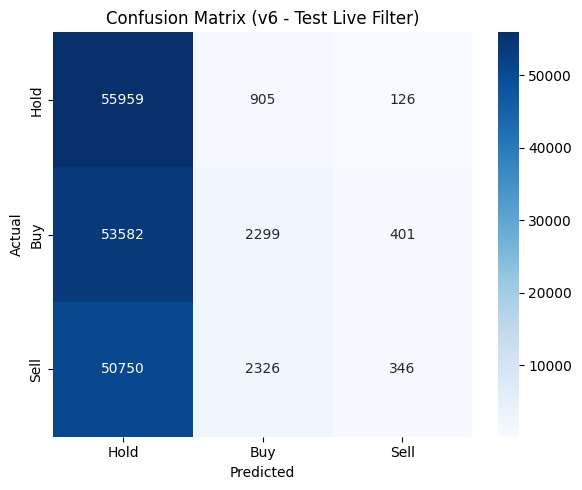

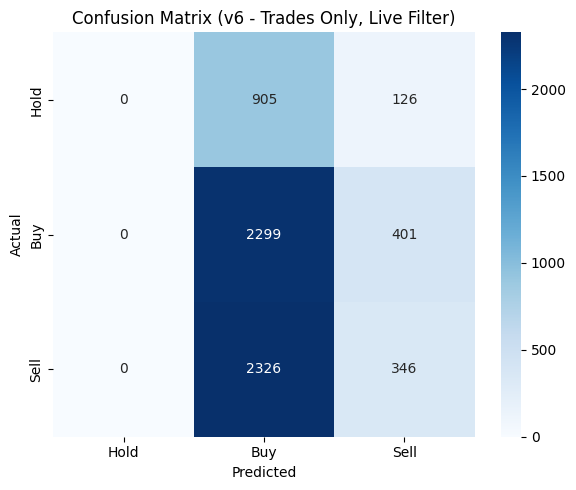


📊 Trading Metrics (Live Filter):
   Eligible Bars: 82,986
   Total Trades: 6,403
   Win Rate: 47.3%
   Total P&L: ¥-745,970
   Avg Win: ¥917
   Avg Loss: ¥-1,045
   Profit Factor: 0.79
   Sharpe Ratio: -14.62

⏳ Running Advanced Backtest (v6)...

📊 BACKTEST RESULTS (v6)

📈 Performance Summary:
   Total Trades: 6,403
   Win Rate: 47.2% (3021 wins / 3382 losses)
   Total P&L: ¥-811,245
   Avg Win: ¥909
   Avg Loss: ¥-1,052
   Profit Factor: 0.77
   Max Drawdown: ¥-894,665 (-4575.1%)

📊 Risk Metrics:
   Sharpe Ratio: -15.90
   Calmar Ratio: 3.97
   Trading Cost: 0.0500 pips/trade
   Bid/Ask Used: True

BUY: 5530 trades, Win Rate: 47.7%, P&L: ¥-724,760

SELL: 873 trades, Win Rate: 44.1%, P&L: ¥-86,485


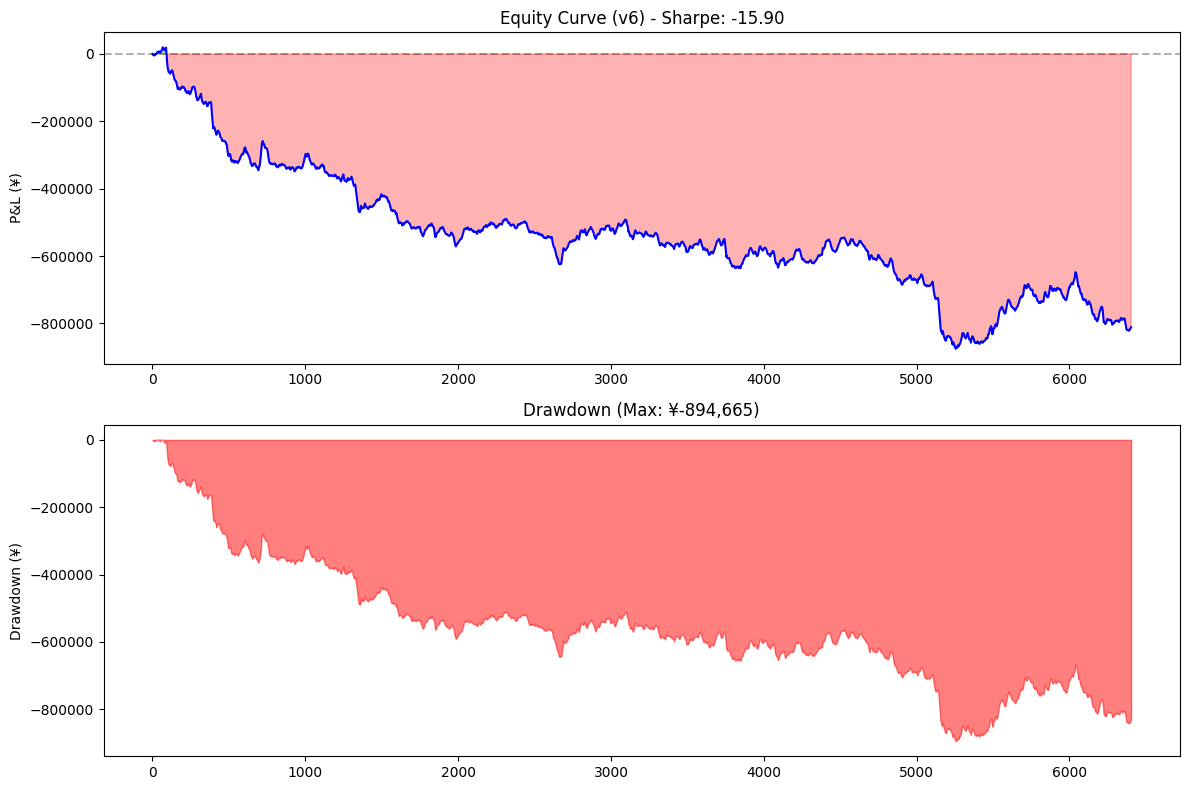

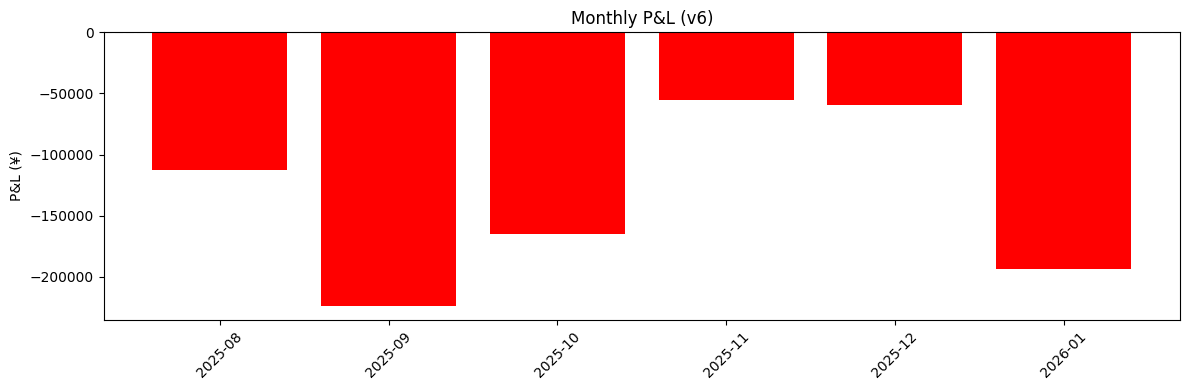

In [15]:
# === Cell 7: Final Evaluation & Advanced Backtest (v6) ===
print("\n" + "="*60)
print("📊 FINAL MODEL EVALUATION ON TEST DATA (v6)")
print("="*60)


def build_live_filter(index, df_features, config, atr_threshold):
    eligible = pd.Series(True, index=index)
    if config['EVAL_USE_BAD_HOURS']:
        eligible &= ~index.hour.isin(config['BAD_HOURS'])
    if config['EVAL_USE_ATR_FILTER'] and 'volatility_atr' in df_features.columns:
        eligible &= df_features.loc[index, 'volatility_atr'] >= atr_threshold
    return eligible


def compute_trade_metrics(preds, future_returns_pips, total_count, config):
    cost_pips = config['SPREAD_PIPS'] + config['SLIPPAGE_PIPS']
    pnl_pips = calc_trade_pnl_pips(preds, future_returns_pips, cost_pips)

    trade_count = len(pnl_pips)
    trade_rate = trade_count / total_count if total_count > 0 else 0.0

    total_pnl_yen = pnl_pips.sum() * config['PIP_SIZE'] * config['POSITION_SIZE']
    win_rate = (pnl_pips > 0).sum() / trade_count * 100 if trade_count > 0 else 0
    avg_win = pnl_pips[pnl_pips > 0].mean() * config['PIP_SIZE'] * config['POSITION_SIZE'] if (pnl_pips > 0).any() else 0
    avg_loss = pnl_pips[pnl_pips < 0].mean() * config['PIP_SIZE'] * config['POSITION_SIZE'] if (pnl_pips < 0).any() else 0
    profit_factor = abs(pnl_pips[pnl_pips > 0].sum() / pnl_pips[pnl_pips < 0].sum()) if (pnl_pips < 0).sum() != 0 else float('inf')
    sharpe = calculate_sharpe_ratio(pnl_pips, config['BAR_PER_YEAR'], trade_rate)

    return {
        'trade_count': trade_count,
        'trade_rate': trade_rate,
        'win_rate': win_rate,
        'total_pnl_yen': total_pnl_yen,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'sharpe': sharpe
    }


def print_classification_metrics(y_true, y_pred, label):
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"\n📈 Overall Metrics ({label}):")

    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Macro F1: {macro_f1:.4f}")
    print(f"   Weighted F1: {weighted_f1:.4f}")
    print(f"   Cohen's Kappa: {kappa:.4f}")

    print(f"\n📊 Classification Report ({label}):")

    print(classification_report(y_true, y_pred, target_names=['Hold', 'Buy', 'Sell']))


def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Hold', 'Buy', 'Sell'],
                yticklabels=['Hold', 'Buy', 'Sell'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    plt.tight_layout()
    plt.show()


# テストデータでの予測
probs_test = model.predict_proba(X_test)
preds_raw = predict_with_thresholds(probs_test, THRESHOLD_BUY, THRESHOLD_SELL)

# === No Filter Evaluation ===
print("\n--- NO FILTER ---")
print_classification_metrics(y_test, preds_raw, "Test Set (No Filter)")
plot_confusion(y_test, preds_raw, 'Confusion Matrix (v6 - Test No Filter)')

trade_mask_raw = preds_raw != 0
if trade_mask_raw.any():
    plot_confusion(y_test[trade_mask_raw], preds_raw[trade_mask_raw], 'Confusion Matrix (v6 - Trades Only, No Filter)')
else:
    print("⚠️ No trades generated (no filter).")

metrics_no = compute_trade_metrics(preds_raw, future_returns_pips_test.values, len(preds_raw), CONFIG)
print(f"\n📊 Trading Metrics (No Filter):")

print(f"   Total Trades: {metrics_no['trade_count']:,}")
print(f"   Win Rate: {metrics_no['win_rate']:.1f}%")
print(f"   Total P&L: ¥{metrics_no['total_pnl_yen']:,.0f}")
print(f"   Avg Win: ¥{metrics_no['avg_win']:,.0f}")
print(f"   Avg Loss: ¥{metrics_no['avg_loss']:,.0f}")
print(f"   Profit Factor: {metrics_no['profit_factor']:.2f}")
print(f"   Sharpe Ratio: {metrics_no['sharpe']:.2f}")

# === Live Filter Evaluation ===
print("\n--- LIVE FILTER (BAD_HOURS + ATR) ---")
eligible_mask = build_live_filter(X_test.index, df_features, CONFIG, ATR_THRESHOLD)
preds_live = preds_raw.copy()
preds_live[~eligible_mask.values] = 0

print_classification_metrics(y_test, preds_live, "Test Set (Live Filter)")
plot_confusion(y_test, preds_live, 'Confusion Matrix (v6 - Test Live Filter)')

trade_mask_live = preds_live != 0
if trade_mask_live.any():
    plot_confusion(y_test[trade_mask_live], preds_live[trade_mask_live], 'Confusion Matrix (v6 - Trades Only, Live Filter)')
else:
    print("⚠️ No trades generated (live filter).")

metrics_live = compute_trade_metrics(preds_live, future_returns_pips_test.values, int(eligible_mask.sum()), CONFIG)
print(f"\n📊 Trading Metrics (Live Filter):")

print(f"   Eligible Bars: {int(eligible_mask.sum()):,}")
print(f"   Total Trades: {metrics_live['trade_count']:,}")
print(f"   Win Rate: {metrics_live['win_rate']:.1f}%")
print(f"   Total P&L: ¥{metrics_live['total_pnl_yen']:,.0f}")
print(f"   Avg Win: ¥{metrics_live['avg_win']:,.0f}")
print(f"   Avg Loss: ¥{metrics_live['avg_loss']:,.0f}")
print(f"   Profit Factor: {metrics_live['profit_factor']:.2f}")
print(f"   Sharpe Ratio: {metrics_live['sharpe']:.2f}")


# === Advanced Backtest (v6: Slippage + Live Filters, bid/ask aware) ===
print("\n⏳ Running Advanced Backtest (v6)...")

def run_backtest_v6(model, X_test, y_test, df_prices, df_features, config,
                    atr_threshold, threshold_buy=0.4, threshold_sell=0.4):
    probs = model.predict_proba(X_test)
    test_indices = X_test.index

    use_bid_ask = {'ask_close', 'bid_close'}.issubset(df_prices.columns)
    total_cost_pips = config['SLIPPAGE_PIPS'] if use_bid_ask else (config['SPREAD_PIPS'] + config['SLIPPAGE_PIPS'])
    total_cost = total_cost_pips * config['PIP_SIZE']

    eligible_mask = build_live_filter(test_indices, df_features, config, atr_threshold)

    results = []
    equity_curve = [0]
    eligible_bars = 0

    for i, idx in enumerate(test_indices):
        if not eligible_mask.iloc[i]:
            continue

        # 決済価格（PREDICT_HORIZON分後）
        exit_idx = idx + pd.Timedelta(minutes=config['PREDICT_HORIZON'])
        if exit_idx not in df_prices.index:
            continue

        eligible_bars += 1

        buy_prob = probs[i, 1]
        sell_prob = probs[i, 2]
        actual = y_test.iloc[i]

        if use_bid_ask:
            entry_buy = df_prices.loc[idx, 'ask_close']
            exit_buy = df_prices.loc[exit_idx, 'bid_close']
            entry_sell = df_prices.loc[idx, 'bid_close']
            exit_sell = df_prices.loc[exit_idx, 'ask_close']
        else:
            entry_buy = df_prices.loc[idx, 'close']
            exit_buy = df_prices.loc[exit_idx, 'close']
            entry_sell = df_prices.loc[idx, 'close']
            exit_sell = df_prices.loc[exit_idx, 'close']

        signal = None
        pnl = 0

        if buy_prob > threshold_buy and buy_prob > sell_prob:
            signal = 'BUY'
            pnl = (exit_buy - entry_buy - total_cost) * config['POSITION_SIZE']
        elif sell_prob > threshold_sell and sell_prob > buy_prob:
            signal = 'SELL'
            pnl = (entry_sell - exit_sell - total_cost) * config['POSITION_SIZE']

        if signal:
            results.append({
                'timestamp': idx,
                'signal': signal,
                'entry_price': entry_buy if signal == 'BUY' else entry_sell,
                'exit_price': exit_buy if signal == 'BUY' else exit_sell,
                'buy_prob': buy_prob,
                'sell_prob': sell_prob,
                'actual': actual,
                'pnl': pnl,
                'win': pnl > 0
            })
            equity_curve.append(equity_curve[-1] + pnl)

    if not results:
        return None, None, eligible_bars, use_bid_ask, total_cost_pips

    df_results = pd.DataFrame(results)
    return df_results, equity_curve, eligible_bars, use_bid_ask, total_cost_pips


# バックテスト実行
df_bt, equity, eligible_bars, used_bid_ask, cost_pips_used = run_backtest_v6(
    model, X_test, y_test, df, df_features, CONFIG,
    ATR_THRESHOLD,
    threshold_buy=THRESHOLD_BUY,
    threshold_sell=THRESHOLD_SELL
)

if df_bt is not None:
    print("\n" + "="*60)
    print("📊 BACKTEST RESULTS (v6)")
    print("="*60)

    total_trades = len(df_bt)
    wins = df_bt['win'].sum()
    losses = total_trades - wins
    win_rate = wins / total_trades * 100

    total_pnl = df_bt['pnl'].sum()
    avg_win = df_bt[df_bt['win']]['pnl'].mean() if wins > 0 else 0
    avg_loss = df_bt[~df_bt['win']]['pnl'].mean() if losses > 0 else 0
    profit_factor = abs(df_bt[df_bt['pnl'] > 0]['pnl'].sum() / df_bt[df_bt['pnl'] < 0]['pnl'].sum()) if df_bt[df_bt['pnl'] < 0]['pnl'].sum() != 0 else float('inf')

    # ドローダウン計算
    equity_series = pd.Series(equity)
    running_max = equity_series.cummax()
    drawdown = equity_series - running_max
    max_drawdown = drawdown.min()
    max_dd_pct = (max_drawdown / running_max.max() * 100) if running_max.max() > 0 else 0

    # Sharpe Ratio
    trade_rate = total_trades / eligible_bars if eligible_bars > 0 else 0
    sharpe_ratio = calculate_sharpe_ratio(df_bt['pnl'].values, CONFIG['BAR_PER_YEAR'], trade_rate)

    # Calmar Ratio（年率リターン / 最大ドローダウン）
    avg_trade_pnl = total_pnl / total_trades if total_trades > 0 else 0
    expected_trades_per_year = CONFIG['BAR_PER_YEAR'] * trade_rate
    annual_return = avg_trade_pnl * expected_trades_per_year
    calmar_ratio = abs(annual_return / max_drawdown) if max_drawdown != 0 else float('inf')

    print(f"\n📈 Performance Summary:")

    print(f"   Total Trades: {total_trades:,}")
    print(f"   Win Rate: {win_rate:.1f}% ({wins} wins / {losses} losses)")
    print(f"   Total P&L: ¥{total_pnl:,.0f}")
    print(f"   Avg Win: ¥{avg_win:,.0f}")
    print(f"   Avg Loss: ¥{avg_loss:,.0f}")
    print(f"   Profit Factor: {profit_factor:.2f}")
    print(f"   Max Drawdown: ¥{max_drawdown:,.0f} ({max_dd_pct:.1f}%)")

    print(f"\n📊 Risk Metrics:")

    print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"   Calmar Ratio: {calmar_ratio:.2f}")
    print(f"   Trading Cost: {cost_pips_used:.4f} pips/trade")
    print(f"   Bid/Ask Used: {used_bid_ask}")

    # Buy/Sell別統計
    for signal in ['BUY', 'SELL']:
        df_sig = df_bt[df_bt['signal'] == signal]
        if len(df_sig) > 0:
            sig_wr = df_sig['win'].sum() / len(df_sig) * 100
            sig_pnl = df_sig['pnl'].sum()
            print(f"\n{signal}: {len(df_sig)} trades, Win Rate: {sig_wr:.1f}%, P&L: ¥{sig_pnl:,.0f}")


    # エクイティカーブ
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    axes[0].plot(equity, color='blue')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].fill_between(range(len(equity)), equity, 0,
                         where=[e >= 0 for e in equity], alpha=0.3, color='green')
    axes[0].fill_between(range(len(equity)), equity, 0,
                         where=[e < 0 for e in equity], alpha=0.3, color='red')
    axes[0].set_title(f'Equity Curve (v6) - Sharpe: {sharpe_ratio:.2f}')
    axes[0].set_ylabel('P&L (¥)')

    axes[1].fill_between(range(len(drawdown)), drawdown, 0, alpha=0.5, color='red')
    axes[1].set_title(f'Drawdown (Max: ¥{max_drawdown:,.0f})')
    axes[1].set_ylabel('Drawdown (¥)')

    plt.tight_layout()
    plt.show()

    # 月次パフォーマンス
    df_bt['month'] = df_bt['timestamp'].dt.to_period('M')
    monthly_pnl = df_bt.groupby('month')['pnl'].sum()

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = ['green' if p > 0 else 'red' for p in monthly_pnl.values]
    ax.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors)
    ax.set_xticks(range(len(monthly_pnl)))
    ax.set_xticklabels([str(m) for m in monthly_pnl.index], rotation=45)
    ax.set_title('Monthly P&L (v6)')
    ax.set_ylabel('P&L (¥)')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No trades generated. Adjust thresholds or check data.")



In [16]:
# === Cell 8: Save Artifacts (v6) ===
print("⏳ Saving artifacts (v6)...")

model_path = ARTIFACT_DIR / "catboost_usdjpy_v6.cbm"
model.save_model(model_path)

features_path = ARTIFACT_DIR / "selected_features_v6.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(selected_features, f)

# v6: 最適化された閾値とATR閾値を保存
config_v6 = CONFIG.copy()
config_v6['THRESHOLD_PIPS'] = BEST_THRESHOLD_PIPS
config_v6['THRESHOLD_BUY'] = THRESHOLD_BUY
config_v6['THRESHOLD_SELL'] = THRESHOLD_SELL
config_v6['ATR_THRESHOLD'] = ATR_THRESHOLD

config_path = ARTIFACT_DIR / "config_v6.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config_v6, f)

print(f"\n✅ Model saved as '{model_path}'")

print(f"✅ Features list saved as '{features_path}'")
print(f"✅ Config saved as '{config_path}'")

for p in [model_path, features_path, config_path]:
    if p.exists():
        maybe_download(p)



⏳ Saving artifacts (v6)...

✅ Model saved as 'artifacts\catboost_usdjpy_v6.cbm'
✅ Features list saved as 'artifacts\selected_features_v6.pkl'
✅ Config saved as 'artifacts\config_v6.pkl'
📁 Saved locally: artifacts\catboost_usdjpy_v6.cbm
📁 Saved locally: artifacts\selected_features_v6.pkl
📁 Saved locally: artifacts\config_v6.pkl


In [17]:
# === Cell 9: Load Model & Verify (v6) ===
import pickle
from catboost import CatBoostClassifier

print("⏳ Loading Model & Verifying (v6)...")

model_path = ARTIFACT_DIR / "catboost_usdjpy_v6.cbm"
features_path = ARTIFACT_DIR / "selected_features_v6.pkl"
config_path = ARTIFACT_DIR / "config_v6.pkl"

if not all(p.exists() for p in [model_path, features_path, config_path]):
    raise FileNotFoundError("🚨 Model or config files not found. Please run Cell 8 first.")

# モデルロード
loaded_model = CatBoostClassifier()
loaded_model.load_model(str(model_path))
print(f"✅ Model loaded from '{model_path}'")

# 特徴量ロード
with open(features_path, 'rb') as f:
    loaded_features = pickle.load(f)
print(f"✅ Features list loaded ({len(loaded_features)} features)")

# 設定ロード
with open(config_path, 'rb') as f:
    loaded_config = pickle.load(f)
print(f"✅ Config loaded")

# 閾値を変数に保存（推論で使用）
THRESHOLD_BUY_FINAL = loaded_config['THRESHOLD_BUY']
THRESHOLD_SELL_FINAL = loaded_config['THRESHOLD_SELL']

print(f"\n📊 Ready for Inference (v6):")

print(f"   THRESHOLD_PIPS: {loaded_config['THRESHOLD_PIPS']:.4f}")
print(f"   Buy Threshold: {THRESHOLD_BUY_FINAL:.4f}")
print(f"   Sell Threshold: {THRESHOLD_SELL_FINAL:.4f}")
print(f"   Slippage: {loaded_config['SLIPPAGE_PIPS']:.4f} pips")
print(f"   Timezone: {loaded_config.get('TIMEZONE', 'UTC')}")



⏳ Loading Model & Verifying (v6)...
✅ Model loaded from 'artifacts\catboost_usdjpy_v6.cbm'
✅ Features list loaded (40 features)
✅ Config loaded

📊 Ready for Inference (v6):
   THRESHOLD_PIPS: 2.2339
   Buy Threshold: 0.4400
   Sell Threshold: 0.4600
   Slippage: 0.0500 pips
   Timezone: UTC


In [18]:
# === Cell 10: Realtime Inference (v6 with GMO Coin FX API) ===
import requests
import json
import pandas as pd
from datetime import datetime, timedelta, timezone
import numpy as np
import ta


def fetch_gmo_data_v6(symbol='USD_JPY', interval='1min', days=5):
    # GMOコインの外国為替FX Public APIから直近データを取得
    base_url = "https://forex-api.coin.z.com/public/v1/klines"
    jst_now = datetime.now(timezone.utc) + timedelta(hours=9)

    dates_to_fetch = [(jst_now - timedelta(days=i)).strftime('%Y%m%d') for i in range(days)]
    dates_to_fetch.reverse()

    all_data = []
    for date_str in dates_to_fetch:
        try:
            params = {
                'symbol': symbol,
                'interval': interval,
                'date': date_str,
                'priceType': 'ASK'
            }
            response = requests.get(base_url, params=params, timeout=10)
            data = response.json()

            if data['status'] == 0 and data['data']:
                all_data.extend(data['data'])
        except Exception as e:
            print(f"⚠️ API Fetch Error for {date_str}: {e}")
            continue

    if not all_data:
        raise ValueError("❌ Failed to fetch data. Check API status or symbol.")

    df = pd.DataFrame(all_data)

    if 'openTime' not in df.columns:
        raise ValueError('Missing openTime in API response')

    open_raw = pd.to_numeric(df['openTime'], errors='coerce')
    if open_raw.isna().all():
        # Fallback: parse as datetime strings
        ts = pd.to_datetime(df['openTime'], utc=True, errors='coerce')
    else:
        max_abs = open_raw.dropna().abs().max()
        if max_abs < 1e11:
            unit = 's'
        elif max_abs < 1e14:
            unit = 'ms'
        elif max_abs < 1e17:
            unit = 'us'
        else:
            unit = 'ns'
        ts = pd.to_datetime(open_raw, unit=unit, utc=True, errors='coerce')

    if ts.isna().any():
        bad = int(ts.isna().sum())
        print(f"WARN: dropped {bad} rows with invalid openTime")

    df['openTime'] = ts
    df = df.dropna(subset=['openTime'])
    df = df.set_index('openTime').sort_index()
    df = df[~df.index.duplicated(keep='last')]

    for c in ['open', 'high', 'low', 'close']:
        df[c] = df[c].astype(float)

    df.rename(columns={
        'open': 'ask_open',
        'high': 'ask_high',
        'low': 'ask_low',
    }, inplace=True)

    if 'volume' not in df.columns:
        df['volume'] = 1.0

    return df


def predict_signal_v6(model, features, config, threshold_buy, threshold_sell):
    print("⏳ Fetching Realtime Data from GMO Coin FX API...")

    try:
        base_df = fetch_gmo_data_v6(symbol='USD_JPY', days=5)
    except Exception as e:
        return f"🚨 DATA ERROR: {e}"

    if len(base_df) < 500:
        return f"⚠️ NOT ENOUGH DATA: {len(base_df)} rows (Need > 500)"

    base_df, price_cols = select_ohlc_columns_v6(base_df)

    # 特徴量生成
    calc_df = generate_features_v6(base_df, price_cols)

    # 最新行を取得
    latest_row = calc_df.tail(1)
    latest_time = latest_row.index[0]

    # 欠損特徴量のチェック
    missing_features = [f for f in features if f not in calc_df.columns]
    if missing_features:
        print(f"⚠️ Missing features: {missing_features}")
        for f in missing_features:
            calc_df[f] = 0

    X_latest = latest_row[features].fillna(0)

    # フィルタリング
    curr_hour = latest_time.hour
    curr_atr = calc_df['volatility_atr'].iloc[-1] if 'volatility_atr' in calc_df.columns else 0.0
    atr_threshold = config.get('ATR_THRESHOLD', 0.0)
    curr_close = calc_df['close'].iloc[-1]

    res_prefix = f"[{latest_time.strftime('%Y-%m-%d %H:%M')} {config.get('TIMEZONE','UTC')}] {curr_close:.3f} | "

    if config.get('EVAL_USE_BAD_HOURS', True) and curr_hour in config['BAD_HOURS']:
        return res_prefix + f"🛑 SKIP (Low Liquidity Hour: {curr_hour}h {config.get('TIMEZONE','UTC')})"

    if config.get('EVAL_USE_ATR_FILTER', True) and atr_threshold > 0 and curr_atr < atr_threshold:
        return res_prefix + f"💤 SKIP (Low Vol: ATR {curr_atr:.4f} < {atr_threshold:.4f})"

    # 予測
    probs = model.predict_proba(X_latest)[0]
    hold_p, buy_p, sell_p = probs[0], probs[1], probs[2]

    if buy_p > threshold_buy and buy_p > sell_p:
        return res_prefix + f"🚀 BUY SIGNAL (Prob: {buy_p:.1%}, Confidence: {buy_p-sell_p:.1%})"
    elif sell_p > threshold_sell and sell_p > buy_p:
        return res_prefix + f"↘️ SELL SIGNAL (Prob: {sell_p:.1%}, Confidence: {sell_p-buy_p:.1%})"
    else:
        return res_prefix + f"👀 WAIT (Hold:{hold_p:.1%} Buy:{buy_p:.1%} Sell:{sell_p:.1%})"


# === 実行 ===
print(f"📊 Config (v6):")
print(f"   THRESHOLD_PIPS: {loaded_config['THRESHOLD_PIPS']:.4f}")
print(f"   Buy Threshold: {THRESHOLD_BUY_FINAL:.4f}")
print(f"   Sell Threshold: {THRESHOLD_SELL_FINAL:.4f}")
print(f"   Bad Hours (UTC): {loaded_config['BAD_HOURS']}")


decision = predict_signal_v6(
    loaded_model,
    loaded_features,
    loaded_config,
    THRESHOLD_BUY_FINAL,
    THRESHOLD_SELL_FINAL
)
print(f"\n🎯 Result: {decision}")




📊 Config (v6):
   THRESHOLD_PIPS: 2.2339
   Buy Threshold: 0.4400
   Sell Threshold: 0.4600
   Bad Hours (UTC): [20, 21, 22, 23]
⏳ Fetching Realtime Data from GMO Coin FX API...
⚠️ API Fetch Error for 20260204: 'status'

🎯 Result: [2026-02-03 15:30 UTC] 155.817 | 👀 WAIT (Hold:34.9% Buy:41.8% Sell:40.6%)


⏳ Analyzing Feature Importance with SHAP (v6)...


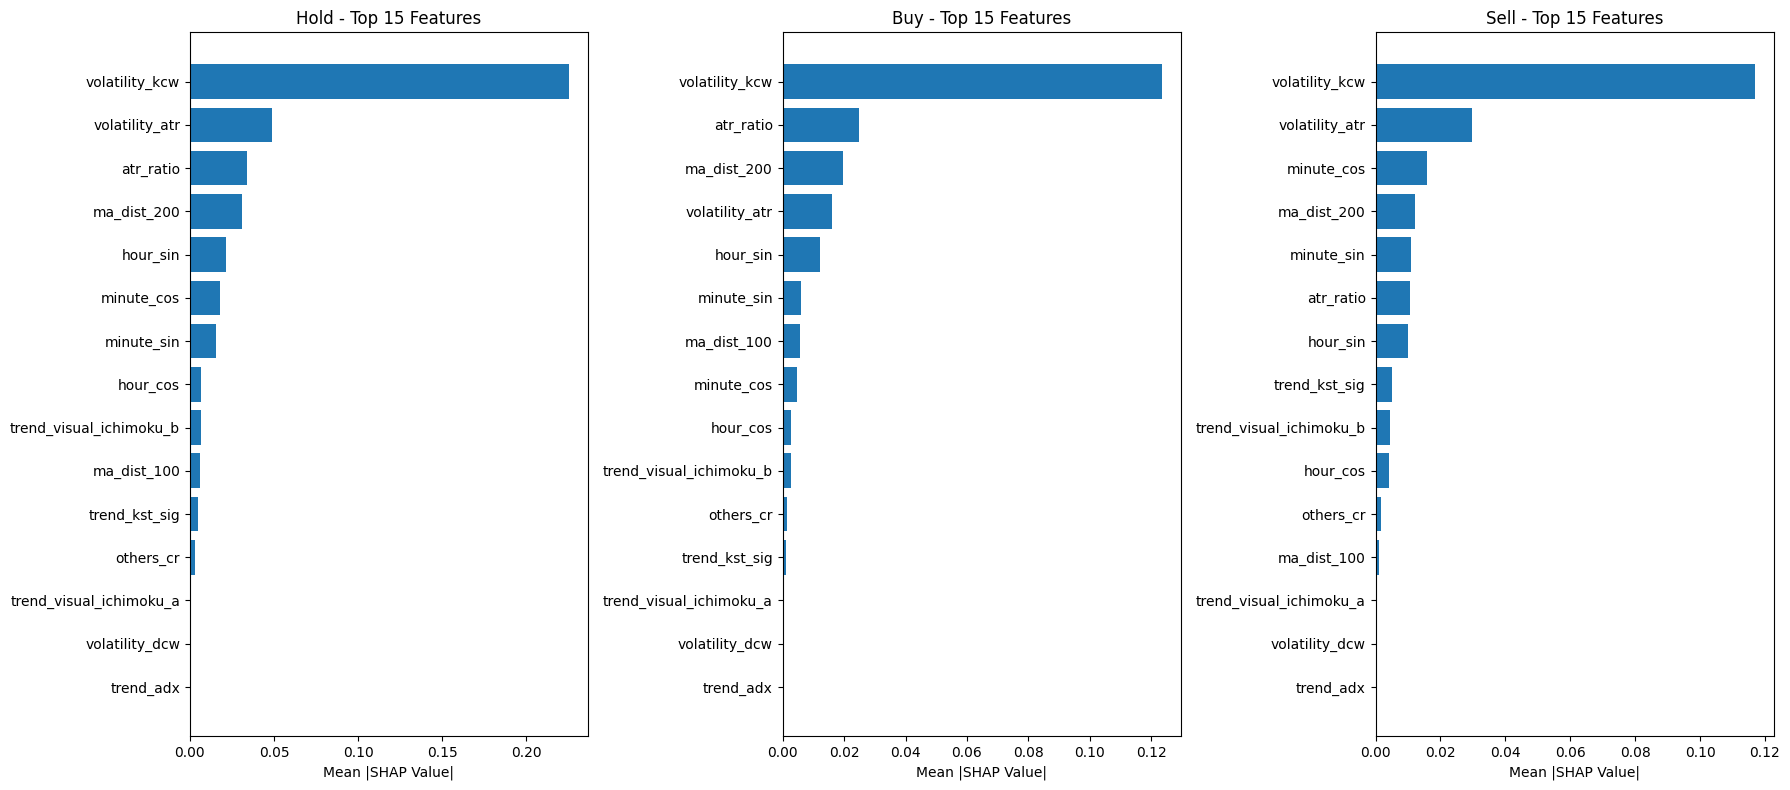

✅ SHAP analysis completed and saved as 'shap_analysis_v6.png'


In [19]:
# === Cell 11: SHAP Feature Importance Analysis (v6) ===
print("⏳ Analyzing Feature Importance with SHAP (v6)...")

# サンプルデータ（計算時間短縮のため）
sample_size = min(5000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=CONFIG['RANDOM_SEED'])

# SHAP計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# クラス別SHAP importance
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
class_names = ['Hold', 'Buy', 'Sell']

for i, (ax, name) in enumerate(zip(axes, class_names)):
    if isinstance(shap_values, list):
        sv = shap_values[i]
    else:
        sv = shap_values[:, :, i]

    importance = np.abs(sv).mean(axis=0)
    sorted_idx = np.argsort(importance)[-15:]

    ax.barh(range(len(sorted_idx)), importance[sorted_idx])
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([selected_features[i] for i in sorted_idx])
    ax.set_title(f'{name} - Top 15 Features')
    ax.set_xlabel('Mean |SHAP Value|')

plt.tight_layout()
out_path = Path("shap_analysis_v6.png")
plt.savefig(out_path, dpi=150)
plt.show()
print(f"✅ SHAP analysis completed and saved as '{out_path}'")

